<a href="https://colab.research.google.com/github/Muzi-HS/2023ML/blob/main/%EB%8B%AE%EC%9D%80%EA%BC%B4%EC%B0%BE%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>3분 만에 전이 학습(Transfer Learning)을 활용한 인공지능 서비스 만들기</b>

* 본 프로젝트에서는 세 가지 기능을 합쳐서 순식간에 상용 인공지능 서비스를 제작합니다.
    1. 이미지 크롤링(image crawling) 혹은 크롤링 라이브러리
    2. 전이 학습(transfer learning)
    3. 웹 API 개발
* 이 프로젝트에서 만들어 볼 것은 <b>마동석/김종국/이병헌</b> 분류기(classifier)입니다.
* 단 <b>3분</b> 만에 인공지능 개발의 전체 과정을 진행합니다.
    * 데이터 수집/정제
    * 인공지능 모델 학습
    * 학습된 모델 배포
* 한글 폰트 설치 이후에 <b>[런타임] - [런타임 다시 시작]</b>을 수행해야 합니다.

In [ ]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
#matplotlib.font_manager._rebuild()

!pip install koreanize-matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import koreanize_matplotlib

#### <b>1. 이미지 크롤링을 활용한 학습 이미지 수집</b>

* 수집한 이미지를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의합니다.

In [8]:
import os
import shutil


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir('/content/drive/MyDrive/image/' + query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.copyfile('/content/drive/MyDrive/image/'+ query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.copyfile('/content/drive/MyDrive/image/'+ query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1

* <b>아이돌</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다. (27명)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


* <b>유명 연예인 및 배우</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다. (25명)

In [10]:
# /content/drive/MyDrive/image


query = '아이유'
dataset_split(query, 25)

query = '유재석'
dataset_split(query, 25)

query = '지수'
dataset_split(query, 25)

query = '민규'
dataset_split(query, 25)


[Train Dataset] 9.jpeg
[Train Dataset] 8.jpeg
[Train Dataset] 7.jpeg
[Train Dataset] 3.jpeg
[Train Dataset] 4.jpeg
[Train Dataset] 6.jpeg
[Train Dataset] 30.jpeg
[Train Dataset] 29.jpeg
[Train Dataset] 5.jpeg
[Train Dataset] 28.jpeg
[Train Dataset] 25.jpeg
[Train Dataset] 20.jpeg
[Train Dataset] 24.jpeg
[Train Dataset] 26.jpeg
[Train Dataset] 23.jpeg
[Train Dataset] 27.jpeg
[Train Dataset] 21.jpeg
[Train Dataset] 2.jpeg
[Train Dataset] 22.jpeg
[Train Dataset] 19.jpeg
[Train Dataset] 18.jpeg
[Train Dataset] 17.jpeg
[Train Dataset] 16.jpeg
[Train Dataset] 11.jpeg
[Train Dataset] 13.jpeg
[Test Dataset] 12.jpeg
[Test Dataset] 10.jpeg
[Test Dataset] 15.jpeg
[Test Dataset] 14.jpeg
[Test Dataset] 1.jpeg
[Train Dataset] 8.jpg
[Train Dataset] 28.jpg
[Train Dataset] 27.jpg
[Train Dataset] 26.jpg
[Train Dataset] 2.jpg
[Train Dataset] 22.jpg
[Train Dataset] 21.jpg
[Train Dataset] 25.jpg
[Train Dataset] 23.jpg
[Train Dataset] 24.jpg
[Train Dataset] 20.jpg
[Train Dataset] 19.jpg
[Train Dataset] 13.j

* <b>이병헌</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

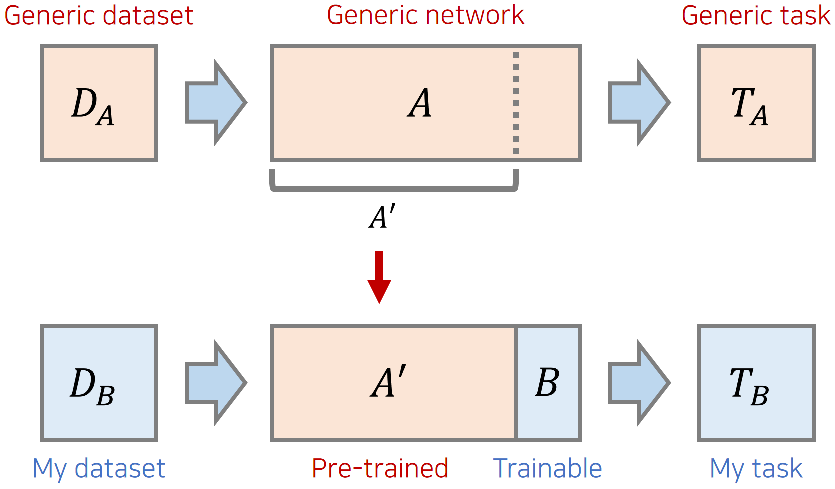

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [12]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 100
테스트 데이터셋 크기: 23
클래스: ['민규', '아이유', '유재석', '지수']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


* 간단히 이미지를 시각화해 봅시다.

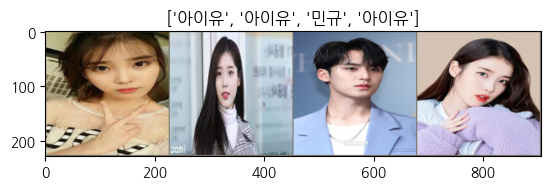

In [13]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [14]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 44.7MB/s]


* 학습을 진행합니다.

In [15]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 1.1828 Acc: 54.0000% Time: 9.6517s
#1 Loss: 0.5964 Acc: 79.0000% Time: 11.4294s
#2 Loss: 0.3330 Acc: 88.0000% Time: 13.0538s
#3 Loss: 0.2882 Acc: 91.0000% Time: 15.3562s
#4 Loss: 0.2860 Acc: 91.0000% Time: 17.8364s
#5 Loss: 0.4156 Acc: 84.0000% Time: 19.4713s
#6 Loss: 0.2420 Acc: 90.0000% Time: 21.5126s
#7 Loss: 0.1599 Acc: 94.0000% Time: 23.2077s
#8 Loss: 0.1183 Acc: 96.0000% Time: 24.8851s
#9 Loss: 0.2952 Acc: 89.0000% Time: 26.5202s
#10 Loss: 0.2253 Acc: 94.0000% Time: 28.3554s
#11 Loss: 0.3005 Acc: 86.0000% Time: 30.9401s
#12 Loss: 0.2806 Acc: 90.0000% Time: 33.0041s
#13 Loss: 0.2240 Acc: 90.0000% Time: 34.6790s
#14 Loss: 0.0997 Acc: 97.0000% Time: 36.3376s
#15 Loss: 0.1313 Acc: 96.0000% Time: 37.9775s
#16 Loss: 0.1402 Acc: 94.0000% Time: 39.5641s
#17 Loss: 0.1044 Acc: 95.0000% Time: 41.3285s
#18 Loss: 0.0672 Acc: 98.0000% Time: 43.4452s
#19 Loss: 0.1065 Acc: 97.0000% Time: 46.0498s
#20 Loss: 0.1321 Acc: 97.0000% Time: 47.9152s
#21 Loss: 0.3191 Acc: 91.0000% Time: 49.5458s

* 학습된 모델을 평가합니다.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[예측 결과: 유재석] (실제 정답: 민규)


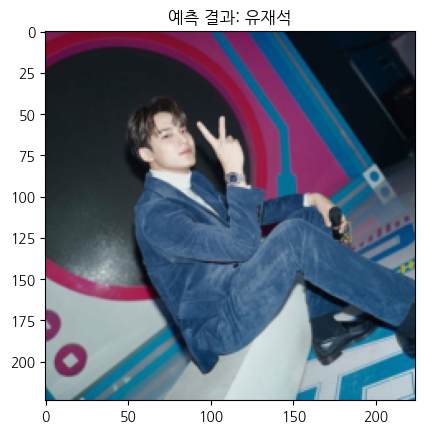

[예측 결과: 지수] (실제 정답: 지수)


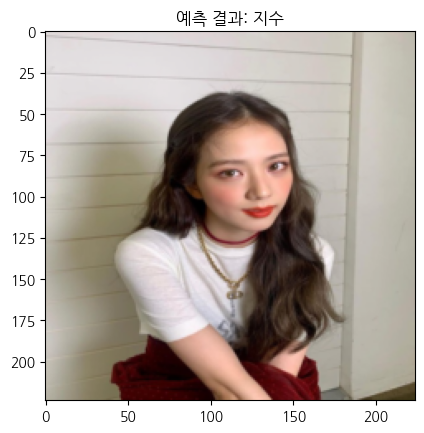

[예측 결과: 유재석] (실제 정답: 유재석)


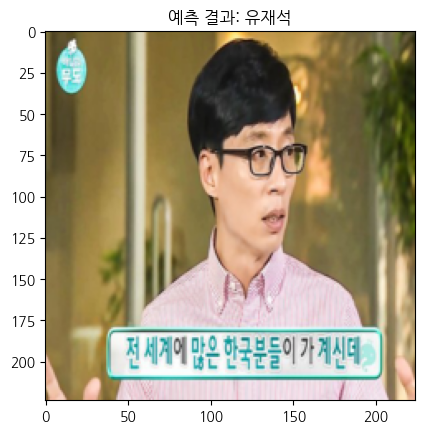

[예측 결과: 아이유] (실제 정답: 아이유)


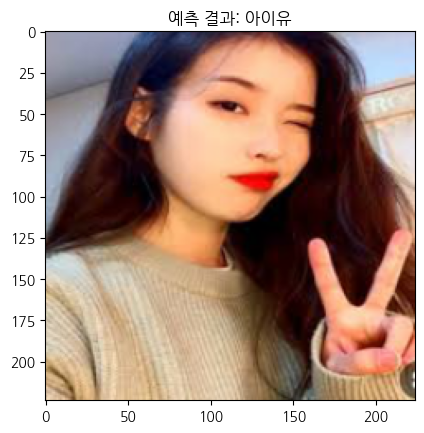

[예측 결과: 민규] (실제 정답: 민규)


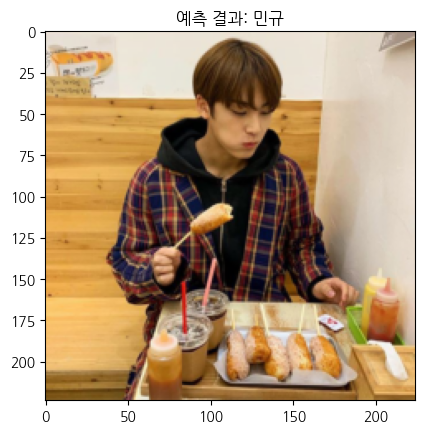

[예측 결과: 지수] (실제 정답: 지수)


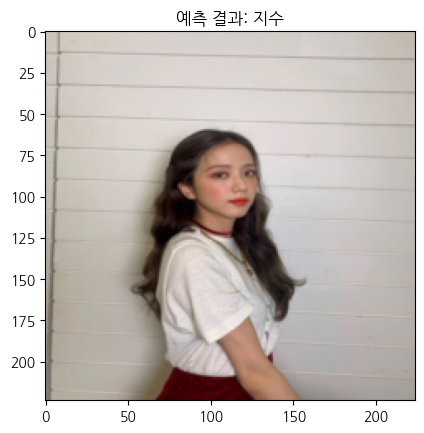

[Test Phase] Loss: 0.6954 Acc: 78.2609% Time: 2.6121s
(23, 4)


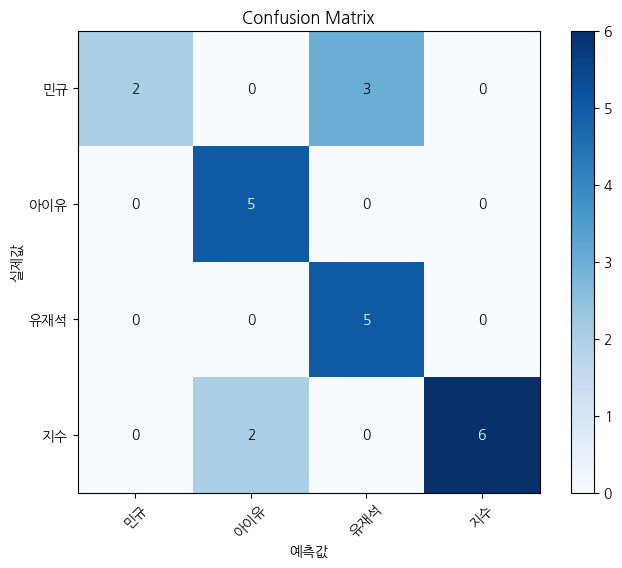

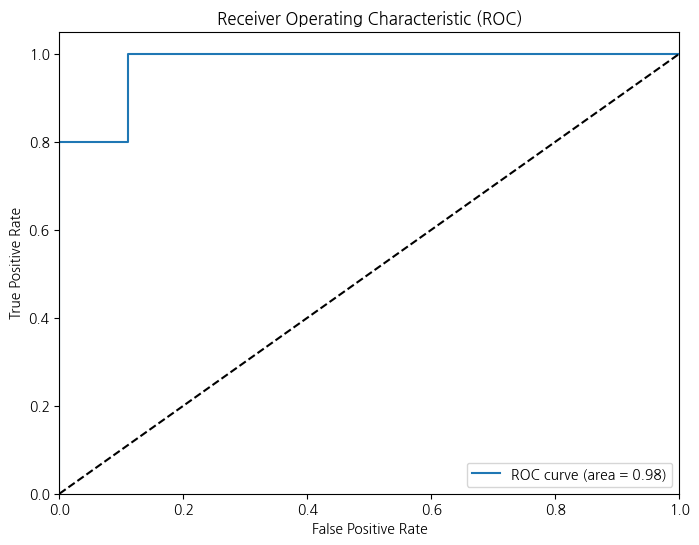

F1 스코어: 0.7578
Precision: 0.8348
Recall: 0.7875
Accuracy: 0.7826


In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, accuracy_score

# ...

# 모델 평가
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0
    all_preds = []  # 예측 값들을 저장할 리스트
    all_labels = []  # 실제 레이블들을 저장할 리스트
    probs = []  # 확률값을 저장할 리스트

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())  # 예측 값들을 리스트에 추가
        all_labels.extend(labels.data.cpu().numpy())  # 실제 레이블들을 리스트에 추가

        probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())  # 확률값들을 리스트에 추가

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

    # `probs`와 `all_labels`의 길이를 확인하고 조정
    if len(probs) != len(all_labels):
        print("Error: Number of samples in `probs` and `all_labels` do not match.")
        exit()

    # `probs`의 shape 확인
    probs = np.array(probs)
    print(probs.shape)

# Confusion Matrix 계산
confusion = confusion_matrix(all_labels, all_preds)

# Precision 계산
precision = precision_score(all_labels, all_preds, average='macro')

# Recall 계산
recall = recall_score(all_labels, all_preds, average='macro')

# Accuracy 계산
accuracy = accuracy_score(all_labels, all_preds)

# Confusion Matrix 출력
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('예측값')
plt.ylabel('실제값')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, confusion[i, j], ha='center', va='center', color='white' if confusion[i, j] > np.max(confusion) / 2 else 'black')
plt.show()

# ROC Curve 계산 및 그리기
fpr, tpr, thresholds = roc_curve(all_labels, probs[:, 1], pos_label=1)  # ROC Curve 계산
roc_auc = auc(fpr, tpr)  # AUC 계산

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# F1 Score 계산
f1 = f1_score(all_labels, all_preds, average='macro')

print('F1 스코어: {:.4f}'.format(f1))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('Accuracy: {:.4f}'.format(accuracy))


#### <b>3. 분류 모델 API 개발</b>

* 학습된 분류 모델을 다른 사람이 사용할 수 있도록 API를 개발하여 배포합니다.
* 먼저 한 장의 이미지를 파일로부터 읽어와 분류 결과를 반환하는 기능을 작성합니다.

In [ ]:
# 테스트용 이미지 다운로드하기
!wget https://upload.wikimedia.org/wikipedia/commons/f/f1/Don_Lee_by_Gage_Skidmore.jpg -O test_image.jpg

--2023-05-21 06:33:27--  https://upload.wikimedia.org/wikipedia/commons/f/f1/Don_Lee_by_Gage_Skidmore.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4070584 (3.9M) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>]   3.88M  19.0MB/s    in 0.2s    

2023-05-21 06:33:28 (19.0 MB/s) - ‘test_image.jpg’ saved [4070584/4070584]



In [ ]:
from PIL import Image


image = Image.open('test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

NameError: ignored

* 웹 API 개방을 위해 <b>Ngrok</b> 서비스를 이용합니다.
* API 기능 제공을 위해 <b>Flask 프레임워크</b>를 사용합니다.

In [ ]:
# 필요한 라이브러리 설치하기
!pip install flask-ngrok

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

* API를 개방할 수 있으며 실행할 때마다 서버의 주소가 변경됩니다.
* 서버 주소를 정확히 확인할 필요가 있습니다.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c4cdb8de3a35.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


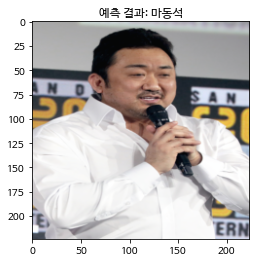

127.0.0.1 - - [23/Feb/2021 08:06:33] "POST / HTTP/1.1" 200 -


결과: {'class_name': '마동석'}


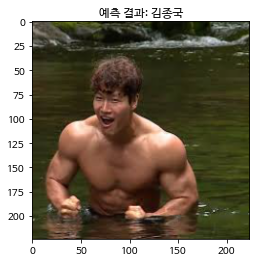

127.0.0.1 - - [23/Feb/2021 08:06:51] "POST / HTTP/1.1" 200 -


결과: {'class_name': '김종국'}


In [ ]:
run_with_ngrok(app)
app.run()

* 클라이언트 테스트 방법

<pre>
curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}
</pre>

* 사용 예시

<pre>
curl -X POST -F file=@dongseok.jpg http://c4cdb8de3a35.ngrok.io/
</pre>

* 이러한 방식으로 웹, 모바일, 게임 등의 소프트웨어 환경에서 API를 호출하는 방식으로 인공지능 앱을 개발할 수 있습니다.